In [152]:
import osmnx as ox
import pandas as pd

import numpy as np
import matplotlib.pyplot as pl

import networkx as nx

import os

In [153]:


ox.config(log_file=True, log_console=True, use_cache=True)



In [154]:
#Just qc graph
place=['Québec city, canada']


graphQc = ox.graph_from_place(place, 
                       simplify=False,
                       retain_all=True)



In [155]:
#geopandas ie sf like
qcCity = ox.gdf_from_place(place[0])
qcCity.head()

bbox_east  bbox_north  bbox_south  bbox_west  \
0 -71.133661    46.98068    46.72771 -71.549217   

                                            geometry  \
0  POLYGON ((-71.5492175 46.8511815, -71.5313905 ...   

                                          place_name  
0  Quebec City, Québec (Agglomération), Capitale-...

In [156]:
print( type(graphQc) )
print( type(qcCity))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'geopandas.geodataframe.GeoDataFrame'>


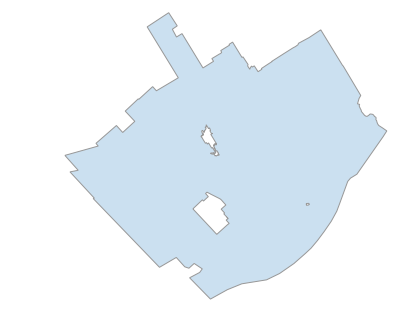

In [24]:
city = ox.project_gdf(qcCity)
fig, ax = ox.plot_shape(city)

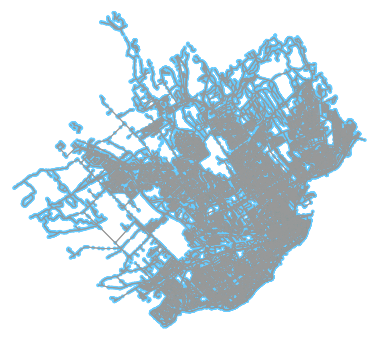

In [30]:
#this is f**long nx.draw(graphQc)
fig, ax = ox.plot_graph(graphQc)

In [157]:
dictBbox={"xmin": -71.24047, 
        "ymin" :  46.79089,
        "xmax" : -71.19298,
        "ymax" : 46.83216 }
matBbox=np.array([v for k, v in dictBbox.items() ]).reshape(2,2).transpose()
dict2={}
dict2["key"] = ["min","max"]
dict2["lng"] = matBbox[0,:]
dict2["lat"] = matBbox[1,:]
dfBbox=pd.DataFrame.from_dict(dict2)
dfBbox

key       lng       lat
0  min -71.24047  46.79089
1  max -71.19298  46.83216

In [158]:

dfBbox["dummy"] = np.ones(dfBbox.shape[0])

dfMerged=pd.merge(dfBbox,dfBbox,
        on="dummy")

dfExtremePoints=dfMerged.loc[:, ["lat_y","lng_x"]]  #permute lat lng for omsnx
dfExtremePoints

lat_y     lng_x
0  46.79089 -71.24047
1  46.83216 -71.24047
2  46.79089 -71.19298
3  46.83216 -71.19298

In [159]:
centroid=dfExtremePoints.apply( lambda x: np.mean(x))
print(type(centroid))
centroid.values

<class 'pandas.core.series.Series'>


array([ 46.811525, -71.216725])

In [160]:
bufferMeters=1*10**3
graphQcReduced = ox.graph_from_point(centroid.values,distance=bufferMeters) #use a buffer of 10 km around the centroid of the bounding box

In [11]:
fig, ax= ox.plot_graph(graphQcReduced)

In [161]:
 dfMerged

key_x     lng_x     lat_x  dummy key_y     lng_y     lat_y
0   min -71.24047  46.79089    1.0   min -71.24047  46.79089
1   min -71.24047  46.79089    1.0   max -71.19298  46.83216
2   max -71.19298  46.83216    1.0   min -71.24047  46.79089
3   max -71.19298  46.83216    1.0   max -71.19298  46.83216

In [162]:
ROOT_DIR = "/home/dhw3172/projects/Plaques" 

In [190]:
dfStreets=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","Streets", "uniqueStreetsWithLngLat.csv"),delimiter=";")

In [191]:
dfStreets=dfStreets.loc[ ~dfStreets.isna().any(axis=1),  ]
dfStreets.reset_index(inplace=True) #reset the index
dfStreets

index                  Street   lngStart   latStart     lngEnd     latEnd
0      0     rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753
1      1      rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131
2      5           rue Richelieu -71.228021  46.806901 -71.213253  46.813998
3      9      rue Saint-Jean sjb -71.227488  46.806574 -71.215778  46.812134
4     10  rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147  46.814640
5     17        Grande-Allée Est -71.222752  46.802777 -71.212004  46.808976
6     20              rue du Roi -71.231359  46.812907 -71.217596  46.817295
7     29           rue Couillard -71.209135  46.814698 -71.208100  46.815313
8     35              rue Hébert -71.206288  46.815469 -71.204298  46.815730

In [192]:
def checkWithinInterval(x, xmin, xmax):
    return( (x <= xmax) & (x >= xmin))

In [193]:
#Make sure within the bouding box
def checkBoxRow(i, dfStreets, dfBox):
    return( 
        checkWithinInterval( dfStreets.loc[i, "lngStart"] , dfBox.loc [0, "lng_x"] , dfBox.loc [3, "lng_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "lngEnd"]   , dfBox.loc [0,"lng_x"] ,  dfBox.loc [3,"lng_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "latStart"] , dfBox.loc [0,"lat_x"] ,  dfBox.loc [3,"lat_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "latEnd"]   , dfBox.loc [0,"lat_x"] ,  dfBox.loc [3,"lat_y"] )
  )


In [194]:
checkBoxRow( 0, dfStreets, dfMerged )
dfMerged.loc [3,"lng_y"] <= dfStreets.loc [3,"lngStart"]
dfStreets.loc [0,"lngStart"]
(dfStreets.loc[0, "lngStart"] >= dfMerged.loc [0, "lng_x"]) & (dfStreets.loc[0, "lngStart"] <= dfMerged.loc [3, "lng_y"] ) 

checkBoxRow( 0, dfStreets, dfMerged )

True

In [21]:
colorMapNodes = ["b" if ox.is_endpoint(G=graphQcReduced,node=n) else "r" for n in graphQcReduced.nodes()]
ox.plot_graph(graphQcReduced,node_color=colorMapNodes )

(<Figure size 630.034x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefbdebff28>)

In [195]:
dfConcat=pd.concat( [dfStreets.loc[: ,["lngStart", "latStart"]].rename(columns={"lngStart":"lng", "latStart": "lat"})  ,
            dfStreets.loc[: ,["lngEnd", "latEnd"]].rename(columns={"lngEnd":"lng", "latEnd": "lat"}) ] ,
            ignore_index=True)
dfConcat.tail()

lng        lat
13 -71.209147  46.814640
14 -71.212004  46.808976
15 -71.217596  46.817295
16 -71.208100  46.815313
17 -71.204298  46.815730

In [196]:
dfConcatNew=dfConcat.drop_duplicates(keep="first")
print("removed", dfConcat.shape[0]-dfConcatNew.shape[0], "duplicate rows")
print(dfConcat.duplicated())

removed 1 duplicate rows
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13    False
14    False
15    False
16    False
17    False
dtype: bool


In [212]:
#Watch out with the index!
dfConcat = dfConcatNew.copy()
dfConcat.reset_index(inplace=True)
dfConcat
#[ str(dfConcat.loc[i,"lng"]) + "_" + str(dfConcat.loc[i,"lat"]) for i in range(dfConcat.shape[0])]

index        lng        lat
0       0 -71.211626  46.808025
1       1 -71.228938  46.807552
2       2 -71.228021  46.806901
3       3 -71.227488  46.806574
4       4 -71.215778  46.812134
5       5 -71.222752  46.802777
6       6 -71.231359  46.812907
7       7 -71.209135  46.814698
8       8 -71.206288  46.815469
9       9 -71.222580  46.801753
10     10 -71.220098  46.812131
11     11 -71.213253  46.813998
12     13 -71.209147  46.814640
13     14 -71.212004  46.808976
14     15 -71.217596  46.817295
15     16 -71.208100  46.815313
16     17 -71.204298  46.815730

In [213]:
numNodes=len(graphQcReduced.nodes())
listIndices=[k[0] for k in graphQcReduced.nodes.items()]

In [214]:
dummyStart=max(listIndices)+1
for i in range(dfConcat.shape[0]): 
     graphQcReduced.add_node(dummyStart+i , 
                             x=dfConcat.loc[i,"lng"] , 
                             y=dfConcat.loc[i,"lat"])
dfConcat["index"] = [dummyStart+i for i in range(dfConcat.shape[0])]
print(dfConcat.shape)
dfConcat


(17, 3)


index        lng        lat
0   6336677220 -71.211626  46.808025
1   6336677221 -71.228938  46.807552
2   6336677222 -71.228021  46.806901
3   6336677223 -71.227488  46.806574
4   6336677224 -71.215778  46.812134
5   6336677225 -71.222752  46.802777
6   6336677226 -71.231359  46.812907
7   6336677227 -71.209135  46.814698
8   6336677228 -71.206288  46.815469
9   6336677229 -71.222580  46.801753
10  6336677230 -71.220098  46.812131
11  6336677231 -71.213253  46.813998
12  6336677232 -71.209147  46.814640
13  6336677233 -71.212004  46.808976
14  6336677234 -71.217596  46.817295
15  6336677235 -71.208100  46.815313
16  6336677236 -71.204298  46.815730

In [215]:
dfStreets.head(3)
print(dfStreets.shape)

(9, 6)


In [216]:
dfStreetsMergedStart=pd.merge( dfStreets, dfConcat, 
         how="left",
         left_on=["lngStart","latStart"],
         right_on =["lng","lat"])
dfStreetsMergedStart.rename(columns={"index_y":"idxStart"} ,inplace=True)

In [217]:
dfStreetsMergedStartEnd=pd.merge( dfStreetsMergedStart, dfConcat, 
         how="left",
         left_on=["lngEnd","latEnd"],
         right_on =["lng","lat"])
dfStreetsMergedStartEnd
dfStreetsMergedStartEnd.rename(columns={"index":"idxEnd"} ,inplace=True)

In [218]:
dfStreetsMergedStartEnd.head(3)
print(dfStreetsMergedStartEnd.shape)

(9, 12)


In [219]:

newColMap = [  "r" for k in range(len(listIndices)) ] + ["b" for k in range(dfConcat.shape[0])]

In [98]:
ox.plot_graph(graphQcReduced,node_color=newColMap )

(<Figure size 630.034x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefbd8d4160>)

In [220]:
type(graphQcReduced)

networkx.classes.multidigraph.MultiDiGraph

In [241]:
dfStreetsMergedStartEnd.head()

index_x                  Street   lngStart   latStart     lngEnd  \
0        0     rue Wilfrid-Laurier -71.211626  46.808025 -71.222580   
1        1      rue de la Tourelle -71.228938  46.807552 -71.220098   
2        5           rue Richelieu -71.228021  46.806901 -71.213253   
3        9      rue Saint-Jean sjb -71.227488  46.806574 -71.215778   
4       10  rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147   

      latEnd    idxStart      lng_x      lat_x      idxEnd      lng_y  \
0  46.801753  6336677220 -71.211626  46.808025  6336677229 -71.222580   
1  46.812131  6336677221 -71.228938  46.807552  6336677230 -71.220098   
2  46.813998  6336677222 -71.228021  46.806901  6336677231 -71.213253   
3  46.812134  6336677223 -71.227488  46.806574  6336677224 -71.215778   
4  46.814640  6336677224 -71.215778  46.812134  6336677232 -71.209147   

       lat_y  
0  46.801753  
1  46.812131  
2  46.813998  
3  46.812134  
4  46.814640

In [248]:
dfStreetsMergedStartEnd.loc[0,["lngStart","latStart"]].tolist()
geopy.distance.vincenty(dfStreetsMergedStartEnd.loc[0,["lngStart","latStart"]].tolist() ,
                        dfStreetsMergedStartEnd.loc[0,["lngEnd", "latEnd"] ].tolist())


/home/dhw3172/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until


Distance(1.24284033519255)

In [251]:
import geopy.distance

def computeDistanceRow(dfStreetsMergedStartEnd, k):
    return( 
        geopy.distance.vincenty(dfStreetsMergedStartEnd.loc[k,["lngStart","latStart"]].tolist() , 
                            dfStreetsMergedStartEnd.loc[k,["lngEnd", "latEnd"] ].tolist() )
          ).m

    
dfStreetsMergedStartEnd["distance"] = [computeDistanceRow(dfStreetsMergedStartEnd,i) for i in range(dfStreetsMergedStartEnd.shape[0])]
dfStreetsMergedStartEnd.head()

/home/dhw3172/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


index_x                  Street   lngStart   latStart     lngEnd  \
0        0     rue Wilfrid-Laurier -71.211626  46.808025 -71.222580   
1        1      rue de la Tourelle -71.228938  46.807552 -71.220098   
2        5           rue Richelieu -71.228021  46.806901 -71.213253   
3        9      rue Saint-Jean sjb -71.227488  46.806574 -71.215778   
4       10  rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147   

      latEnd    idxStart      lng_x      lat_x      idxEnd      lng_y  \
0  46.801753  6336677220 -71.211626  46.808025  6336677229 -71.222580   
1  46.812131  6336677221 -71.228938  46.807552  6336677230 -71.220098   
2  46.813998  6336677222 -71.228021  46.806901  6336677231 -71.213253   
3  46.812134  6336677223 -71.227488  46.806574  6336677224 -71.215778   
4  46.814640  6336677224 -71.215778  46.812134  6336677232 -71.209147   

       lat_y     distance  
0  46.801753  1242.840335  
1  46.812131   999.974435  
2  46.813998  1667.399534  
3  46.812134  1321.762175  
4  46.814640   745.334564

In [221]:
for k in range(dfStreetsMergedStartEnd.shape[0]):
    graphQcReduced.add_edge(u_for_edge=dfStreetsMergedStartEnd.loc[k,"idxStart"],
                            v_for_edge=dfStreetsMergedStartEnd.loc[k,"idxEnd"],
                           color="b")
    

In [231]:
#[ e for e in graphQcReduced.edges()]
listEdgesNew=[k[:2] for k,v in nx.get_edge_attributes(graphQcReduced,"color").items() ]

In [236]:
edgeColors=[ "b" if e in listEdgesNew else "gray" for e in graphQcReduced.edges()]

In [237]:
ox.plot_graph(graphQcReduced , edge_color=edgeColors)

(<Figure size 637.767x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fefbde897f0>)

6336677178

In [252]:
import seaborn as sns

In [253]:
sns.barplot(dfStreetsMergedStartEnd["Street"],
           dfStreetsMergedStartEnd["distance"])

In [258]:
dfPlaques=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","WithLngLat", "AllNeighbourhoods", "plaquesTidyManTweak.csv"))
dfPlaques.head()

Unnamed: 0            accuracy  \
0           0  RANGE_INTERPOLATED   
1           1             ROOFTOP   
2           2             ROOFTOP   
3           3  RANGE_INTERPOLATED   
4           4             ROOFTOP   

                                   formatted_address  \
0  85 Rue Wilfrid-Laurier, Sherbrooke, QC J1C 0P3...   
1  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
2  16 Avenue Wilfrid-Laurier, Québec, QC G1R 2K7,...   
3    559 Rue Saint Gabriel, Montréal, QC H2Y, Canada   
4        49 Rue Aberdeen, Québec, QC G1R 2C6, Canada   

                                     google_place_id  \
0  EjY4NSBSdWUgV2lsZnJpZC1MYXVyaWVyLCBTaGVyYnJvb2...   
1                        ChIJQxgec3qWuEwR0egFgivENsI   
2                        ChIJV2IOYn-WuEwRYYlFg0cqNU8   
3  Eiw1NTkgUnVlIFNhaW50IEdhYnJpZWwsIE1vbnRyw6lhbC...   
4                        ChIJg3-hL3-WuEwR6MZoNRYzDGA   

                               input_string   latitude  longitude  \
0     85, rue Wilfrid-Laurier,Quebec,Canada  46.802202 -71.221648   
1     166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
2  16, avenue Wilfrid-Laurier,Quebec,Canada  46.801998 -71.222519   
3      559, rue Saint-Gabriel,Quebec,Canada  46.809447 -71.220046   
4            49, rue Aberdeen,Quebec,Canada  46.803411 -71.224442   

   number_of_results postcode status            type               Name  \
0                  3  G1R 2K6     OK  street_address     Alleyn, Edmund   
1                  1  G1R 1C4     OK  street_address      Angers, Henri   
2                  1  G1R 2K7     OK         premise       Beetz, Johan   
3                  1  G1R 1W3     OK  street_address  Belley, Henriette   
4                  1  G1R 2C6     OK  street_address    Blatter, Robert   

                      Address      Neighbourhood                  Street  \
0     85, rue Wilfrid-Laurier  SaintJeanBaptiste     rue Wilfrid-Laurier   
1     166, rue de la Tourelle  SaintJeanBaptiste      rue de la Tourelle   
2  16, avenue Wilfrid-Laurier  SaintJeanBaptiste  avenue Wilfrid-Laurier   
3      559, rue Saint-Gabriel  SaintJeanBaptiste       rue Saint-Gabriel   
4            49, rue Aberdeen  SaintJeanBaptiste            rue Aberdeen   

            Borough  
0  La Cité-Limoilou  
1  La Cité-Limoilou  
2  La Cité-Limoilou  
3  La Cité-Limoilou  
4  La Cité-Limoilou

In [261]:
dfPlaquesWithStreetDist=pd.merge(dfPlaques, dfStreetsMergedStartEnd,
         how="left",
         on="Street")

In [264]:
dfPlaquesWithStreetDistnoNas=dfPlaquesWithStreetDist.dropna()
dfPlaquesWithStreetDistnoNas.head()

Unnamed: 0            accuracy  \
0            0  RANGE_INTERPOLATED   
1            1             ROOFTOP   
5            5             ROOFTOP   
12          12             ROOFTOP   
20          20             ROOFTOP   

                                    formatted_address  \
0   85 Rue Wilfrid-Laurier, Sherbrooke, QC J1C 0P3...   
1   166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
5       889 Rue Richelieu, Québec, QC G1R 1L1, Canada   
12      734 Rue Richelieu, Québec, QC G1R 1K7, Canada   
20      659 Rue Richelieu, Québec, QC G1R 1K6, Canada   

                                      google_place_id  \
0   EjY4NSBSdWUgV2lsZnJpZC1MYXVyaWVyLCBTaGVyYnJvb2...   
1                         ChIJQxgec3qWuEwR0egFgivENsI   
5                         ChIJV5rUDHaWuEwRL6-jQD1VM5w   
12                        ChIJnZbRXXaWuEwRI9EblZtgWyc   
20                        ChIJ2XrNV3aWuEwREz3XEAH_6ms   

                             input_string   latitude  longitude  \
0   85, rue Wilfrid-Laurier,Quebec,Canada  46.802202 -71.221648   
1   166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
5        889, rue Richelieu,Quebec,Canada  46.812423 -71.217000   
12       734, rue Richelieu,Quebec,Canada  46.811669 -71.219022   
20       659, rue Richelieu,Quebec,Canada  46.811160 -71.219810   

    number_of_results postcode status  ...   latStart     lngEnd     latEnd  \
0                   3  G1R 2K6     OK  ...  46.808025 -71.222580  46.801753   
1                   1  G1R 1C4     OK  ...  46.807552 -71.220098  46.812131   
5                   1  G1R 1L1     OK  ...  46.806901 -71.213253  46.813998   
12                  1  G1R 1K7     OK  ...  46.806901 -71.213253  46.813998   
20                  1  G1R 1K6     OK  ...  46.806901 -71.213253  46.813998   

        idxStart      lng_x      lat_x        idxEnd      lng_y      lat_y  \
0   6.336677e+09 -71.211626  46.808025  6.336677e+09 -71.222580  46.801753   
1   6.336677e+09 -71.228938  46.807552  6.336677e+09 -71.220098  46.812131   
5   6.336677e+09 -71.228021  46.806901  6.336677e+09 -71.213253  46.813998   
12  6.336677e+09 -71.228021  46.806901  6.336677e+09 -71.213253  46.813998   
20  6.336677e+09 -71.228021  46.806901  6.336677e+09 -71.213253  46.813998   

       distance  
0   1242.840335  
1    999.974435  
5   1667.399534  
12  1667.399534  
20  1667.399534  

[5 rows x 28 columns]